### Network Architecture B

- Layer 1 - 300 neurons (ReLU activation function)
- Layer 2 - 100 neurons (ReLU activation function) 
- Layer 2 - SoftMax Layer (10 neurons)

In [0]:
# Colab has two versions of TensorFlow installed: a 1.x version and a 2.x version. 
# Colab currently uses TF 1.x by default
# To enable TF2 execute the following code

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


### Importing the Libraries 

In [0]:
# Importing the libraries 
import tensorflow as tf
from keras.utils import np_utils
import numpy as np 
import matplotlib.pyplot as plt

### L1 Regularisation to Network Architecture B

### Creation of 3 Functions

In [0]:
# -------------------------------------------CODE TO PREPARE THE DATASET---------------------------------------------------- 

def prepare_dataset(fashion_mnist):
  # load the training and test data    
  (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()
  # reshape the feature data
  tr_x = tr_x.reshape(tr_x.shape[0], 784)
  te_x = te_x.reshape(te_x.shape[0], 784)
  # noramlise feature data
  tr_x = tr_x / 255.0
  te_x = te_x / 255.0
  # one hot encode the training labels and get the transpose
  tr_y = np_utils.to_categorical(tr_y,10)
  tr_y = tr_y.T
  # one hot encode the test labels and get the transpose
  te_y = np_utils.to_categorical(te_y,10)
  te_y = te_y.T
  return tr_x, tr_y, te_x, te_y

# -----------------------------------CODE TO CALCULATE THE PROBABILITY OF EACH CLASS GIVEN THE TRAINING INSTANCE--------------------------------------

def forward_pass(X_train, W1, b1, W2, b2, W3, b3):
  """
  Return the predicted 10 class probabilities matrix for each of the training instances 
  """
  # Calculate the pre-activation outputs for each of the 300 neurons in the hidden layer 1 for each of the training instance 
  # Will get 300 outputs for a single training instance in the form of (300*60000) matrix 
  # The size of the W1 is (300*784)
  # The size of the training feature matrix is (784*60000)
  # The size of the b1 is (300*1)
  A1=  tf.matmul(W1, X_train) + b1
  # Convert each element in A1 through relu activation function 
  H1= tf.math.maximum(A1, 0)

  # Calculate the pre-activation outputs for each of the 100 neurons in the hidden layer 2 for each of the training instance 
  # Will get 100 outputs for a single training instance in the form of (100*60000) matrix 
  # The size of the W2 is (100*300)
  # The size of the H1 matrix is (300*60000)
  # The size of the b2 is (100*1)
  A2=  tf.matmul(W2, H1) + b2
  # Convert each element in A1 through relu activation function 
  H2= tf.math.maximum(A2, 0)

  # Calculate the pre-activation outputs for each of the 10 neurons in the softmax layer for each of the training instance 
  # Will get 10 outputs for a single training instance in the form of (10*60000) matrix 
  # The size of the W3 is (10*100)
  # The size of the H2 matrix is (100*60000)
  # The size of the bias matrix b3 is (10*1)
  A3= tf.matmul(W3, H2) + b3
  # Calculate a new matrix where each element is e to the power of pre-activation outputs 
  exponential_matrix= tf.math.exp(A3)
  # Calculation of the final probabilities of each of the 10 classes for each instance in the training set 
  # Column wise sum calculation 
  column_sum= tf.reduce_sum(exponential_matrix, 0)
  # Divide each element by the column sum so that each column is the probability of each class of a single instance 
  H3= exponential_matrix/column_sum 
  # Set the range so that the loss does not come out to be nan 
  H3= tf.clip_by_value(H3 ,1e-10, 1.0) 
  
  return H3

# -------------------------------- CODE TO CALCULATE THE LOSS FOR THE CURRENT SET OF TUNABLE PARAMETERS / WEIGHTS-------------------------------------

def cross_entropy(y_train, y_pred_matrix, W1, W2, W3):
  """
  Return the loss value given the predicted probabilities matrix and the actual probabilities matrix
  Loss function also adds an additional component being the sum of elements in W1, W2 and W3 
  """
  # Compute the log of each element of the prediction matrix 
  log_matrix= tf.math.log(y_pred_matrix)
  # Multiply each element of the actual labels matrix with the log matrix 
  product_matrix= y_train *log_matrix
  # Take the negation of each element in the product matrix 
  negated_product_matrix= -1*(product_matrix)
  # Compute the cross entropy loss for each of the training instances 
  # This will contain individual loss for the all training instances 
  # This operation will perform the column wise sum 
  single_loss_matrix= tf.reduce_sum(negated_product_matrix, 0)
  # Compute the mean cross entropy loss 
  mean_loss= tf.reduce_mean(single_loss_matrix)
  
  # Calculate the sum of elements of W1, W2, W3 
  W1= tf.math.abs(W1)
  W1_sum= tf.math.reduce_sum(W1)
  W2= tf.math.abs(W2)
  W2_sum= tf.math.reduce_sum(W2)
  W3= tf.math.abs(W3)
  W3_sum= tf.math.reduce_sum(W3)
  weights_sum= W1_sum + W2_sum + W3_sum 

  # Multiply the regularisation rate with weights sum 
  reg_rate= 0.0001
  product= reg_rate * weights_sum 
  # Final loss after applying L1 regularisation 
  final_loss= mean_loss + product 

  return final_loss

# ----------------------------------------- CALCULATION OF THE TRAINING AND TEST SET ACCURACY------------------------------------------------------

def return_labels(matrix):
  """
  Return the corrosponding class label for each vector of probability instance 
  """ 
  class_labels= tf.argmax(matrix) 
  
  return class_labels

def calculate_accuracy(feature_data, label_data, W1, b1, W2, b2, W3, b3):
  """ 
  Return the accuracy value (applicable for both train and the test set) for the given set of weights and the biases 
  """
  # Calculate the matrix of predicted probabilities through calling of forward pass 
  predicted_matrix= forward_pass(feature_data, W1, b1, W2, b2, W3, b3)
  # Get the class labels of the actual labels 
  actual_labels= return_labels(label_data)
  # Get the class labels of the predicted probabilities 
  predicted_labels= return_labels(predicted_matrix)
  # Get the correct prediction in the form of boolean array where 1 is correct prediction and 0 is the wrong prediction 
  correct_predictions= tf.cast(tf.equal(predicted_labels, actual_labels), tf.float32)
  # Calculate the accuracy 
  accuracy= tf.reduce_mean(correct_predictions)

  return accuracy 

# ------------------------------------------------BEGINNING OF OUR TENSORFLOW PROGRAM -----------------------------------------------

# Loading the fashion MNIST data-set 
fashion_mnist = tf.keras.datasets.fashion_mnist

# Prepare the dataset 
train_features, train_labels, test_features, test_labels= prepare_dataset(fashion_mnist)

# Get the transpose of feature data 
train_features= train_features.T 
test_features= test_features.T

# Print the shape of our 4 data structures 
print( "Shape of training features ", train_features.shape)
print ("Shape of training labels ", train_labels.shape)
print()
print( "Shape of test features ", test_features.shape)
print ("Shape of test labels ", test_labels.shape)
print()
print("The training process of our Softmax Neural Network begins.....")
print()

X_train= tf.cast(train_features, tf.float32)
y_train= tf.cast(train_labels, tf.float32)
X_test= tf.cast(test_features, tf.float32)
y_test= tf.cast(test_labels, tf.float32)

# Set the Number of features
num_features=  X_train.shape[0]
# We now specify the size of hidden layer 1
hidden1_neurons= 300
# We now specify the size of hidden layer 2
hidden2_neurons= 100
# We now specify the size of output layer 
output_neurons= 10 

# Initialize the weight_matrix 1 and bias_matrix 1 
# Each row of this matrix represents the 784 weights of a single neuron in the hidden layer 
W1= tf.Variable(tf.random.normal([hidden1_neurons, num_features], mean=0.0, stddev=0.05))
# It is a column vector where each row/element represents the bias value for a single neuron in the hidden layer 
b1= tf.Variable(tf.random.normal([hidden1_neurons, 1], mean=0.0, stddev=0.05))

# Initialize the weight_matrix 2 and bias_matrix 2 
# Each row of this matrix represents the 300 weights of a single neuron in the softmax layer 
W2= tf.Variable(tf.random.normal([hidden2_neurons, hidden1_neurons], mean=0.0, stddev=0.05))
# It is a column vector where each row/element represents the bias value for a single neuron in the softmax layer 
b2= tf.Variable(tf.random.normal([hidden2_neurons, 1], mean=0.0, stddev=0.05))

# Initialize the weight_matrix 3 and bias_matrix 3
# Each row of this matrix represents the 300 weights of a single neuron in the softmax layer 
W3= tf.Variable(tf.random.normal([output_neurons, hidden2_neurons], mean=0.0, stddev=0.05))
# It is a column vector where each row/element represents the bias value for a single neuron in the softmax layer 
b3= tf.Variable(tf.random.normal([output_neurons, 1], mean=0.0, stddev=0.05))

# Set the learning rate and the number of iterations 
learning_rate= 0.01
num_iterations= 1200

# Adam optimizer to update the weights of the neural network 
adam_optimizer= tf.keras.optimizers.Adam()

# Create the list to store the training accuracy and loss with each iteration 
training_loss= []
training_acc= []
# Create the list to store the test accuracy and loss with each iteration 
test_loss= []
test_acc= []

# Run the gradient descent to num_iterations number of times 
for iteration in range(num_iterations):
  
  # Create an instance of GradientTape to monitor the forward pass and loss calculations
  with tf.GradientTape() as tape:
    # Calculate the predicted probability matrix for the current weights and the biases for the training set
    y_pred_matrix= forward_pass(X_train, W1, b1, W2, b2, W3, b3)
    # Calculate the predicted probability matrix for the current weights and the biases for the test set
    y_pred_test= forward_pass(X_test, W1, b1, W2, b2, W3, b3)
    # Calculate the current training loss with the current predictions and the actual labels of the training set 
    current_loss_training= cross_entropy(y_train, y_pred_matrix, W1, W2, W3)
    # Calculate the current test loss with the current prediction and the actual labels of the test set 
    current_loss_test= cross_entropy(y_test, y_pred_test, W1, W2, W3)
  
  # Calculate the gradients (partial derivates) of the loss with respect to each of the tunable weights 
  gradients= tape.gradient(current_loss_training, [W1, b1, W2, b2, W3, b3])

  # Calculate the training accuracy with each iteration 
  training_accuracy= calculate_accuracy(X_train, y_train, W1, b1, W2, b2, W3, b3)

  # Calculate the test accuracy with each each iteration 
  test_accuracy= calculate_accuracy(X_test, y_test, W1, b1, W2, b2, W3, b3)

  # Print out the current iteration, current loss and current training accuracy 
  print("Iteration ",iteration, ": Loss = ",current_loss_training.numpy()," Acc: ", training_accuracy.numpy(),   'Val_loss = ',current_loss_test.numpy(),   'Val_acc = ', test_accuracy.numpy())

  # Apply the Adam optimizer to update the weights and biases 
  adam_optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2, W3, b3]))

  # Append the 4 values (train loss, train acc, test loss, test acc) with the each current iteration for the plotting 
  training_loss.append(current_loss_training.numpy())
  training_acc.append(training_accuracy.numpy())
  test_loss.append(current_loss_test.numpy())
  test_acc.append(test_accuracy.numpy())

# Calculate the test accuracy with the final updated weights and the biases through adam optimizer after running for certain number of iterations 
final_test_accuracy= calculate_accuracy(X_test, y_test, W1, b1, W2, b2, W3, b3)

# Print the test accuracy 
print()
print("The final test accuracy of the Fashion MNIST dataset is {}".format(final_test_accuracy))


Shape of training features  (784, 60000)
Shape of training labels  (10, 60000)

Shape of test features  (784, 10000)
Shape of test labels  (10, 10000)

The training process of our Softmax Neural Network begins.....

Iteration  0 : Loss =  3.3752136  Acc:  0.07186667 Val_loss =  3.374908 Val_acc =  0.0692
Iteration  1 : Loss =  3.2523565  Acc:  0.34816667 Val_loss =  3.2527678 Val_acc =  0.3454
Iteration  2 : Loss =  3.1521416  Acc:  0.40265 Val_loss =  3.152936 Val_acc =  0.3982
Iteration  3 : Loss =  3.0534358  Acc:  0.44533333 Val_loss =  3.054955 Val_acc =  0.4434
Iteration  4 : Loss =  2.9481277  Acc:  0.46561667 Val_loss =  2.9505143 Val_acc =  0.4625
Iteration  5 : Loss =  2.835685  Acc:  0.49286667 Val_loss =  2.8391213 Val_acc =  0.4907
Iteration  6 : Loss =  2.7221162  Acc:  0.5298667 Val_loss =  2.726476 Val_acc =  0.527
Iteration  7 : Loss =  2.6088796  Acc:  0.5711167 Val_loss =  2.6139688 Val_acc =  0.5659
Iteration  8 : Loss =  2.4966824  Acc:  0.61151665 Val_loss =  2.50

### Plot of Training/Validation Accuracy and Training/Validation Loss

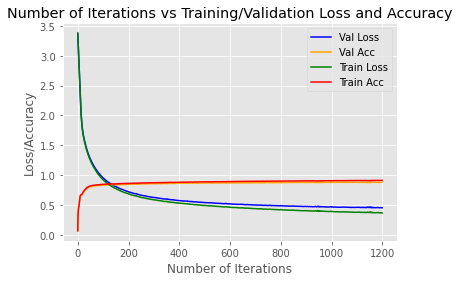


The final test accuracy of the Fashion MNIST dataset is 0.8817999958992004


In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(test_loss, label="Val Loss", color='blue')
plt.plot(test_acc, label="Val Acc", color='orange')
plt.plot(training_loss, label="Train Loss", color='green')
plt.plot(training_acc, label="Train Acc", color='red')
plt.title("Number of Iterations vs Training/Validation Loss and Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
# Print the test accuracy 
print()
print("The final test accuracy of the Fashion MNIST dataset is {}".format(final_test_accuracy))

### L2 regularisation to Netowork Architecture B

In [0]:
# -------------------------------------------CODE TO PREPARE THE DATASET---------------------------------------------------- 

def prepare_dataset(fashion_mnist):
  # load the training and test data    
  (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()
  # reshape the feature data
  tr_x = tr_x.reshape(tr_x.shape[0], 784)
  te_x = te_x.reshape(te_x.shape[0], 784)
  # noramlise feature data
  tr_x = tr_x / 255.0
  te_x = te_x / 255.0
  # one hot encode the training labels and get the transpose
  tr_y = np_utils.to_categorical(tr_y,10)
  tr_y = tr_y.T
  # one hot encode the test labels and get the transpose
  te_y = np_utils.to_categorical(te_y,10)
  te_y = te_y.T
  return tr_x, tr_y, te_x, te_y

# -----------------------------------CODE TO CALCULATE THE PROBABILITY OF EACH CLASS GIVEN THE TRAINING INSTANCE--------------------------------------

def forward_pass(X_train, W1, b1, W2, b2, W3, b3):
  """
  Return the predicted 10 class probabilities matrix for each of the training instances 
  """
  # Calculate the pre-activation outputs for each of the 300 neurons in the hidden layer 1 for each of the training instance 
  # Will get 300 outputs for a single training instance in the form of (300*60000) matrix 
  # The size of the W1 is (300*784)
  # The size of the training feature matrix is (784*60000)
  # The size of the b1 is (300*1)
  A1=  tf.matmul(W1, X_train) + b1
  # Convert each element in A1 through relu activation function 
  H1= tf.math.maximum(A1, 0)

  # Calculate the pre-activation outputs for each of the 100 neurons in the hidden layer 2 for each of the training instance 
  # Will get 100 outputs for a single training instance in the form of (100*60000) matrix 
  # The size of the W2 is (100*300)
  # The size of the H1 matrix is (300*60000)
  # The size of the b2 is (100*1)
  A2=  tf.matmul(W2, H1) + b2
  # Convert each element in A1 through relu activation function 
  H2= tf.math.maximum(A2, 0)

  # Calculate the pre-activation outputs for each of the 10 neurons in the softmax layer for each of the training instance 
  # Will get 10 outputs for a single training instance in the form of (10*60000) matrix 
  # The size of the W3 is (10*100)
  # The size of the H2 matrix is (100*60000)
  # The size of the bias matrix b3 is (10*1)
  A3= tf.matmul(W3, H2) + b3
  # Calculate a new matrix where each element is e to the power of pre-activation outputs 
  exponential_matrix= tf.math.exp(A3)
  # Calculation of the final probabilities of each of the 10 classes for each instance in the training set 
  # Column wise sum calculation 
  column_sum= tf.reduce_sum(exponential_matrix, 0)
  # Divide each element by the column sum so that each column is the probability of each class of a single instance 
  H3= exponential_matrix/column_sum 
  # Set the range so that the loss does not come out to be nan 
  H3= tf.clip_by_value(H3 ,1e-10, 1.0) 
  
  return H3

# -------------------------------- CODE TO CALCULATE THE LOSS FOR THE CURRENT SET OF TUNABLE PARAMETERS / WEIGHTS-------------------------------------

def cross_entropy(y_train, y_pred_matrix, W1, W2, W3):
  """
  Return the loss value given the predicted probabilities matrix and the actual probabilities matrix
  Loss function also adds an additional component being the sum of squared elements in W1, W2 and W3 
  """
  # Compute the log of each element of the prediction matrix 
  log_matrix= tf.math.log(y_pred_matrix)
  # Multiply each element of the actual labels matrix with the log matrix 
  product_matrix= y_train *log_matrix
  # Take the negation of each element in the product matrix 
  negated_product_matrix= -1*(product_matrix)
  # Compute the cross entropy loss for each of the training instances 
  # This will contain individual loss for the all training instances 
  # This operation will perform the column wise sum 
  single_loss_matrix= tf.reduce_sum(negated_product_matrix, 0)
  # Compute the mean cross entropy loss 
  mean_loss= tf.reduce_mean(single_loss_matrix)
  
  # Calculate the sum of squared elements of W1, W2, W3 
  W1_square= tf.math.square(W1)
  W1_sum= tf.math.reduce_sum(W1_square)
  W2_square= tf.math.square(W2)
  W2_sum= tf.math.reduce_sum(W2_square)
  W3_square= tf.math.square(W3)
  W3_sum= tf.math.reduce_sum(W3_square)
  squared_weights_sum= W1_sum + W2_sum + W3_sum 

  # Multiply the regularisation rate with weights sum 
  reg_rate= 0.0001
  product= reg_rate * squared_weights_sum
  # Final loss after applying L2 regularisation 
  final_loss= mean_loss + product 

  return final_loss

# ----------------------------------------- CALCULATION OF THE TRAINING AND TEST SET ACCURACY------------------------------------------------------

def return_labels(matrix):
  """
  Return the corrosponding class label for each vector of probability instance 
  """ 
  class_labels= tf.argmax(matrix) 
  
  return class_labels

def calculate_accuracy(feature_data, label_data, W1, b1, W2, b2, W3, b3):
  """ 
  Return the accuracy value (applicable for both train and the test set) for the given set of weights and the biases 
  """
  # Calculate the matrix of predicted probabilities through calling of forward pass 
  predicted_matrix= forward_pass(feature_data, W1, b1, W2, b2, W3, b3)
  # Get the class labels of the actual labels 
  actual_labels= return_labels(label_data)
  # Get the class labels of the predicted probabilities 
  predicted_labels= return_labels(predicted_matrix)
  # Get the correct prediction in the form of boolean array where 1 is correct prediction and 0 is the wrong prediction 
  correct_predictions= tf.cast(tf.equal(predicted_labels, actual_labels), tf.float32)
  # Calculate the accuracy 
  accuracy= tf.reduce_mean(correct_predictions)

  return accuracy 

# ------------------------------------------------BEGINNING OF OUR TENSORFLOW PROGRAM -----------------------------------------------

# Loading the fashion MNIST data-set 
fashion_mnist = tf.keras.datasets.fashion_mnist

# Prepare the dataset 
train_features, train_labels, test_features, test_labels= prepare_dataset(fashion_mnist)

# Get the transpose of feature data 
train_features= train_features.T 
test_features= test_features.T

# Print the shape of our 4 data structures 
print( "Shape of training features ", train_features.shape)
print ("Shape of training labels ", train_labels.shape)
print()
print( "Shape of test features ", test_features.shape)
print ("Shape of test labels ", test_labels.shape)
print()
print("The training process of our Softmax Neural Network begins.....")
print()

X_train= tf.cast(train_features, tf.float32)
y_train= tf.cast(train_labels, tf.float32)
X_test= tf.cast(test_features, tf.float32)
y_test= tf.cast(test_labels, tf.float32)

# Set the Number of features
num_features=  X_train.shape[0]
# We now specify the size of hidden layer 1
hidden1_neurons= 300
# We now specify the size of hidden layer 2
hidden2_neurons= 100
# We now specify the size of output layer 
output_neurons= 10 

# Initialize the weight_matrix 1 and bias_matrix 1 
# Each row of this matrix represents the 784 weights of a single neuron in the hidden layer 
W1= tf.Variable(tf.random.normal([hidden1_neurons, num_features], mean=0.0, stddev=0.05))
# It is a column vector where each row/element represents the bias value for a single neuron in the hidden layer 
b1= tf.Variable(tf.random.normal([hidden1_neurons, 1], mean=0.0, stddev=0.05))

# Initialize the weight_matrix 2 and bias_matrix 2 
# Each row of this matrix represents the 300 weights of a single neuron in the softmax layer 
W2= tf.Variable(tf.random.normal([hidden2_neurons, hidden1_neurons], mean=0.0, stddev=0.05))
# It is a column vector where each row/element represents the bias value for a single neuron in the softmax layer 
b2= tf.Variable(tf.random.normal([hidden2_neurons, 1], mean=0.0, stddev=0.05))

# Initialize the weight_matrix 3 and bias_matrix 3
# Each row of this matrix represents the 300 weights of a single neuron in the softmax layer 
W3= tf.Variable(tf.random.normal([output_neurons, hidden2_neurons], mean=0.0, stddev=0.05))
# It is a column vector where each row/element represents the bias value for a single neuron in the softmax layer 
b3= tf.Variable(tf.random.normal([output_neurons, 1], mean=0.0, stddev=0.05))

# Set the learning rate and the number of iterations 
learning_rate= 0.01
num_iterations= 1200

# Adam optimizer to update the weights of the neural network 
adam_optimizer= tf.keras.optimizers.Adam()

# Create the list to store the training accuracy and loss with each iteration 
training_loss= []
training_acc= []
# Create the list to store the test accuracy and loss with each iteration 
test_loss= []
test_acc= []

# Run the gradient descent to num_iterations number of times 
for iteration in range(num_iterations):
  
  # Create an instance of GradientTape to monitor the forward pass and loss calculations
  with tf.GradientTape() as tape:
    # Calculate the predicted probability matrix for the current weights and the biases for the training set
    y_pred_matrix= forward_pass(X_train, W1, b1, W2, b2, W3, b3)
    # Calculate the predicted probability matrix for the current weights and the biases for the test set
    y_pred_test= forward_pass(X_test, W1, b1, W2, b2, W3, b3)
    # Calculate the current training loss with the current predictions and the actual labels of the training set 
    current_loss_training= cross_entropy(y_train, y_pred_matrix, W1, W2, W3)
    # Calculate the current test loss with the current prediction and the actual labels of the test set 
    current_loss_test= cross_entropy(y_test, y_pred_test, W1, W2, W3)
  
  # Calculate the gradients (partial derivates) of the loss with respect to each of the tunable weights 
  gradients= tape.gradient(current_loss_training, [W1, b1, W2, b2, W3, b3])

  # Calculate the training accuracy with each iteration 
  training_accuracy= calculate_accuracy(X_train, y_train, W1, b1, W2, b2, W3, b3)

  # Calculate the test accuracy with each each iteration 
  test_accuracy= calculate_accuracy(X_test, y_test, W1, b1, W2, b2, W3, b3)

  # Print out the current iteration, current loss and current training accuracy 
  print("Iteration ",iteration, ": Loss = ",current_loss_training.numpy()," Acc: ", training_accuracy.numpy(),   'Val_loss = ',current_loss_test.numpy(),   'Val_acc = ', test_accuracy.numpy())

  # Apply the Adam optimizer to update the weights and biases 
  adam_optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2, W3, b3]))

  # Append the 4 values (train loss, train acc, test loss, test acc) with the each current iteration for the plotting 
  training_loss.append(current_loss_training.numpy())
  training_acc.append(training_accuracy.numpy())
  test_loss.append(current_loss_test.numpy())
  test_acc.append(test_accuracy.numpy())

# Calculate the test accuracy with the final updated weights and the biases through adam optimizer after running for certain number of iterations 
final_test_accuracy= calculate_accuracy(X_test, y_test, W1, b1, W2, b2, W3, b3)

# Print the test accuracy 
print()
print("The final test accuracy of the Fashion MNIST dataset is {}".format(final_test_accuracy))


Shape of training features  (784, 60000)
Shape of training labels  (10, 60000)

Shape of test features  (784, 10000)
Shape of test labels  (10, 10000)

The training process of our Softmax Neural Network begins.....

Iteration  0 : Loss =  2.3841345  Acc:  0.10226667 Val_loss =  2.384115 Val_acc =  0.1017
Iteration  1 : Loss =  2.2617607  Acc:  0.29883334 Val_loss =  2.2629838 Val_acc =  0.2986
Iteration  2 : Loss =  2.1594565  Acc:  0.41093335 Val_loss =  2.161337 Val_acc =  0.4077
Iteration  3 : Loss =  2.0583239  Acc:  0.474 Val_loss =  2.0607238 Val_acc =  0.468
Iteration  4 : Loss =  1.9520458  Acc:  0.5304 Val_loss =  1.9548502 Val_acc =  0.5224
Iteration  5 : Loss =  1.84087  Acc:  0.58598334 Val_loss =  1.8441254 Val_acc =  0.5786
Iteration  6 : Loss =  1.7260547  Acc:  0.61698335 Val_loss =  1.729918 Val_acc =  0.6114
Iteration  7 : Loss =  1.6105865  Acc:  0.63636667 Val_loss =  1.6153331 Val_acc =  0.63
Iteration  8 : Loss =  1.4965091  Acc:  0.6521 Val_loss =  1.5024225 Val_

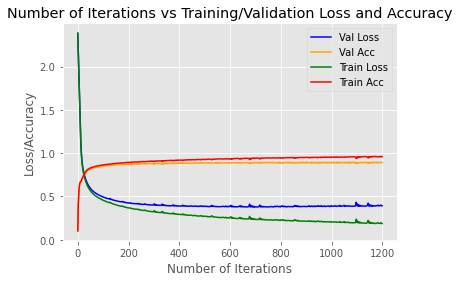


The final test accuracy of the Fashion MNIST dataset is 0.8932999968528748


In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(test_loss, label="Val Loss", color='blue')
plt.plot(test_acc, label="Val Acc", color='orange')
plt.plot(training_loss, label="Train Loss", color='green')
plt.plot(training_acc, label="Train Acc", color='red')
plt.title("Number of Iterations vs Training/Validation Loss and Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
# Print the test accuracy 
print()
print("The final test accuracy of the Fashion MNIST dataset is {}".format(final_test_accuracy))